# Custom Model
## Try with Python 3.8 and tensorflow 2.13.0 

In [2]:
!pip install -q scikit-image seaborn opencv-python-headless split_folders


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()


In [1]:
import tensorflow as tf
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print(tf.__version__)

Built with CUDA: False
GPU Available: []
2.12.0


In [15]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [2]:
import tensorflow as tf
import os
import random
import numpy as np 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import glob
import cv2
import pickle

import math
from PIL import Image
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, Sequential
import seaborn as sb
from tensorflow.keras.layers import Input, Conv2D,AveragePooling2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, Dropout, Lambda, GlobalAveragePooling2D, GaussianNoise, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Layer
from tensorflow.keras.utils import normalize
import splitfolders
from tensorflow.keras.layers import Input, MaxPooling2D, Multiply, Concatenate, UpSampling2D, Conv2D,Conv2DTranspose
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2


In [3]:
IMG_WIDTH = 352
IMG_HEIGHT = 352
IMG_CHANNELS = 3

In [4]:
TRAIN_PATH = "Training"
TEST_PATH = "Testing"

In [5]:
import glob

image_paths = glob.glob("Training/glioma/*.jpg")

for img_path in image_paths[:5]:  # Check first 5 images
    img = cv2.imread(img_path)
    print(img_path, img.shape)


Training/glioma\Tr-glTr_0000.jpg (512, 512, 3)
Training/glioma\Tr-glTr_0001.jpg (512, 512, 3)
Training/glioma\Tr-glTr_0002.jpg (512, 512, 3)
Training/glioma\Tr-glTr_0003.jpg (512, 512, 3)
Training/glioma\Tr-glTr_0004.jpg (512, 512, 3)


In [6]:
data_dir = TRAIN_PATH

# Get class names (folder names)
classes = os.listdir(TRAIN_PATH)

classes.sort()  # optional, just to keep order consistent

X_train = []
Y_train = []

# Loop over each class
for idx, label in enumerate(classes):
    print(label)
    class_path = os.path.join(data_dir, label)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        
        # Read the image
        img = cv2.imread(img_path,cv2.IMREAD_COLOR)
        if img is None:
            continue  # skip bad images
        
        # Resize image (say to 128x128 for uniformity)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        X_train.append(img)
        Y_train.append(idx)  # class index as label

# Convert to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

print(X_train.shape)  # Should be (num_samples, 128, 128, 3)
print(Y_train.shape)  # Should be (num_samples,)


glioma
meningioma
notumor
pituitary
(5712, 352, 352, 3)
(5712,)


In [7]:
Y_train[1321]

1

In [8]:
# Shuffle X_train and Y_train together
from sklearn.utils import shuffle

X_train, Y_train = shuffle(X_train, Y_train, random_state=42)


In [9]:
Y_train[1321]

3

In [10]:
data_dir = TEST_PATH

# Get class names (folder names)
classes = os.listdir(TEST_PATH)
classes.sort()  # optional, just to keep order consistent

X_test = []
Y_test = []

# Loop over each class
for idx, label in enumerate(classes):
    class_path = os.path.join(data_dir, label)
    print(label)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        
        # Read the image
        img = cv2.imread(img_path,cv2.IMREAD_COLOR)
        if img is None:
            continue  # skip bad images
        
        # Resize image (say to 128x128 for uniformity)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        X_test.append(img)
        Y_test.append(idx)  # class index as label

# Convert to numpy arrays
X_test = np.array(X_test)
Y_test = np.array(Y_test)

print(X_test.shape)  # Should be (num_samples, 128, 128, 3)
print(Y_test.shape)  # Should be (num_samples,)


glioma
meningioma
notumor
pituitary
(1311, 352, 352, 3)
(1311,)


In [11]:
Y_test[299]

0

In [12]:
from sklearn.utils import shuffle

X_test, Y_test = shuffle(X_test, Y_test, random_state=42)

In [13]:
X_train = np.array(X_train,dtype=np.uint8)
X_train = (X_train/255.0).astype(np.float32)

In [14]:
print(len(X_train))

5712


In [15]:
print(X_train.shape)

(5712, 352, 352, 3)


In [16]:
X_test = np.array(X_test,dtype=np.uint8)
X_test = (X_test/255.0).astype(np.float32)

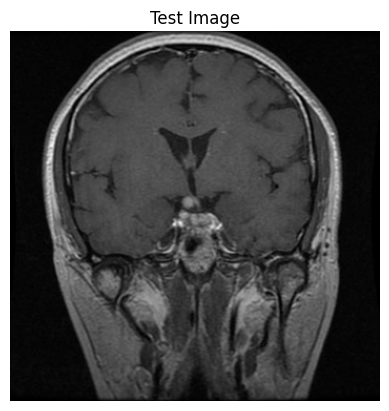

In [16]:
ix = random.randint(0, len(X_train) )

# Display the test image
plt.subplot(1, 1, 1)
plt.imshow(X_train[ix])
plt.title('Test Image')
plt.axis('off')
plt.show()

In [17]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [18]:
model_path = os.path.join("WDFF-NET_files", "model.h5")
csv_path = os.path.join("WDFF-NET_files", "log.csv")

In [19]:
from tensorflow.keras.layers import DepthwiseConv2D, Conv2D, Add, GlobalAveragePooling2D, Dense, Reshape, Multiply

def combined_block(inputs, filters, dilation_rate=2, reduction=16):
    # Step 1: Depthwise Separable Convolution
    x = DepthwiseConv2D(kernel_size=(3, 3), padding="same", strides=(1, 1))(inputs)
    x = Conv2D(filters, kernel_size=(1, 1), padding="same")(x)

    # Step 2: Squeeze-and-Excitation (SE) Block
    se = GlobalAveragePooling2D()(x)
    se = Dense(filters // reduction)(se)
    se = Dense(filters, activation='relu')(se)
    se = Reshape((1, 1, filters))(se)
    x_se = Multiply()([x, se])  # Apply attention weights

    # Step 3: Dilated Convolution for larger receptive fields
    x_dilated = Conv2D(filters, kernel_size=(3, 3), padding="same", dilation_rate=dilation_rate, activation="relu", kernel_regularizer=l2(1e-4))(inputs)

    # Combine outputs
    output = Add()([x_se, x_dilated])  # Fuse SE and dilated features
    return output


In [20]:
from tensorflow.keras.layers import Add, Conv2D

def coin_block(input_tensor,filters=64):
    """
    Implements the overall Coin Block with Involution Layer
    """
    # Initial Conv layers
    conv1 = Conv2D(64, (3, 3), padding='same')(input_tensor)
    conv2 = Conv2D(64, (3, 3), padding='same')(conv1)
    print(f"conv2: {conv2} ")

#     # Involution Layer
#     involution = combined_block(channels=64, kernel_size=7, reduction_ratio=4, stride=1)(conv2)
    
    combined_output = combined_block(conv2, filters)
    
    
    conv_3 = Conv2D(64, (1, 1), padding='same',kernel_regularizer=l2(1e-4))(combined_output)
    
    conv_4 = Conv2D(64, (1, 1), padding='same',kernel_regularizer=l2(1e-4))(conv2)
    
    add_conv_3_4 = Add()([conv_3, conv_4])

    concate_sfa_conv2 = Concatenate()([conv2, add_conv_3_4])

    rfa =  Conv2D(64, (3, 3), padding='same')(concate_sfa_conv2)
    

    return rfa


In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, BatchNormalization, Activation

def conv_block(x, filters, kernel_size=3, activation='relu'):
    x = Conv2D(filters, kernel_size, padding='same',kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

In [ ]:
from keras.layers import BatchNormalizationV2, add
from keras.layers import Conv2D

kernel_initializer = 'he_uniform'


def conv_block_2D(x, filters, block_type, repeat=1, dilation_rate=3, size=3, padding='same'):
    result = x

    for i in range(0, repeat):

        if block_type == 'separated':
            result = separated_conv2D_block(result, filters, size=size, padding=padding)
        elif block_type == 'duckv2':
            result = duckv2_conv2D_block(result, filters, size=size)
        elif block_type == 'midscope':
            result = midscope_conv2D_block(result, filters)
        elif block_type == 'widescope':
            result = widescope_conv2D_block(result, filters)
        elif block_type == 'resnet':
            result = resnet_conv2D_block(result, filters, dilation_rate)
        elif block_type == 'conv':
            result = Conv2D(filters, (size, size),
                            activation='relu', kernel_initializer=kernel_initializer, padding=padding)(result)
        elif block_type == 'double_convolution':
            result = double_convolution_with_batch_normalization(result, filters, dilation_rate)

        else:
            return None

    return result


def duckv2_conv2D_block(x, filters, size):
    x = BatchNormalizationV2(axis=-1)(x)
    x5 = conv_block_2D(x, filters, 'resnet', repeat=3)
    x4= conv_block_2D(x, filters, 'resnet', repeat=3)
    x7=add([x4,x5])
    x6 = separated_conv2D_block(x5, filters, size=6, padding='same')
    x8=separated_conv2D_block(x,filters, size=6, padding='same')
    x = add([x4, x5, x6,x7,x8])

    x = BatchNormalizationV2(axis=-1)(x)

    return x


def separated_conv2D_block(x, filters, size=3, padding='same'):
    x = Conv2D(filters, (1, size), activation='relu', kernel_initializer=kernel_initializer, padding=padding)(x)

    x = BatchNormalizationV2(axis=-1)(x)

    x = Conv2D(filters, (size, 1), activation='relu', kernel_initializer=kernel_initializer, padding=padding)(x)

    x = BatchNormalizationV2(axis=-1)(x)

    return x


def midscope_conv2D_block(x, filters):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=1)(x)

    x = BatchNormalizationV2(axis=-1)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=2)(x)

    x = BatchNormalizationV2(axis=-1)(x)

    return x


def widescope_conv2D_block(x, filters):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=1)(x)

    x = BatchNormalizationV2(axis=-1)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=2)(x)

    x = BatchNormalizationV2(axis=-1)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=3)(x)

    x = BatchNormalizationV2(axis=-1)(x)

    return x


def resnet_conv2D_block(x, filters, dilation_rate=1):
    x1 = Conv2D(filters, (1, 1), activation='relu', kernel_initializer=kernel_initializer, padding='same',
                dilation_rate=dilation_rate)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalizationV2(axis=-1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalizationV2(axis=-1)(x)
    x_final = add([x, x1])

    x_final = BatchNormalizationV2(axis=-1)(x_final)

    return x_final


def double_convolution_with_batch_normalization(x, filters, dilation_rate=1):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalizationV2(axis=-1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalizationV2(axis=-1)(x)

    return x

In [ ]:
import tensorflow as tf 
from tensorflow.keras.layers import BatchNormalization, add, Conv2D, UpSampling2D, Resizing

kernel_initializer = 'he_uniform'

def RAPU(x, filters): 
    x  = BatchNormalization(axis=-1)(x)
    
    x1 = atrous_block(x, filters)
    x2 = resnet_block(x, filters)
    
    x  = add([x1, x2])
    x  = BatchNormalization(axis=-1)(x)

    return x
    
def resnet_block(x, filters,dilation_rate=1):
    x1 = Conv2D(filters, (1, 1), activation='relu', kernel_initializer=kernel_initializer, padding='same',
                dilation_rate=dilation_rate)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)
    x_final = add([x, x1])

    x_final = BatchNormalization(axis=-1)(x_final)

    return x_final    
    
def atrous_block(x, filters):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=1)(x)

    x = BatchNormalization(axis=-1)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=2)(x)

    x = BatchNormalization(axis=-1)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=3)(x)

    x = BatchNormalization(axis=-1)(x)

    return x
    
def convf_bn_act(inputs, filters, kernel_size, strides=(1, 1), activation='relu', padding='same'):
    
    x = Conv2D(filters, kernel_size=kernel_size, strides = strides, padding=padding, use_bias = False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    #x = bn_act(x, activation=activation)
    
    return x    
    
  
    
def SBA(L_input, H_input):
    dim = 16
    
    L_input = Conv2D(dim, 1, padding='same', use_bias=False)(L_input) 
    H_input = Conv2D(dim, 1, padding='same', use_bias=False)(H_input)    
      
    g_L = tf.keras.layers.Activation('sigmoid')(L_input)
    g_H = tf.keras.layers.Activation('sigmoid')(H_input)
    
    L_input = convf_bn_act(L_input,dim,1) 
    H_input = convf_bn_act(H_input,dim,1)   
    
    
    L_feature = L_input + L_input * g_L + (1 - g_L) * UpSampling2D((2,2))(g_H * H_input)
    H_feature = H_input + H_input * g_H + (1 - g_H) * Resizing(H_input.shape[1], H_input.shape[2])(g_L * L_input)
    
    H_feature = UpSampling2D((2,2))(H_feature)
    out = tf.keras.layers.Concatenate(axis=-1)([L_feature, H_feature])
    
    out = convf_bn_act(out, dim*2, 3)
    out = Conv2D(1, 1, use_bias=False)(out)
    
    return out 

In [ ]:
def convf_bn_act(inputs, filters, kernel_size, strides=(1, 1), activation='relu', padding='same'):
    
    x = Conv2D(filters, kernel_size=kernel_size, strides = strides, padding=padding, use_bias = False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    #x = bn_act(x, activation=activation)
    
    return x    

In [ ]:

from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, MaxPooling2D, Multiply, Concatenate, UpSampling2D, Conv2D,Conv2DTranspose,Add
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf
import tensorflow_addons as tfa


def build_mobilenetv2_with_decoder(input_shape):   
    inputs = Input(shape=input_shape, name="input_image")
    encoder = MobileNetV2(include_top=False, weights="imagenet", input_tensor=inputs, alpha=1.4)
    E1 = encoder.get_layer("input_image").output  
    E2 = encoder.get_layer("block_1_expand_relu").output  
    E3 = encoder.get_layer("block_3_expand_relu").output  
    E4 = encoder.get_layer("block_6_expand_relu").output  
    E5 = encoder.get_layer("block_13_expand_relu").output  
    
# Encoder Block

    E1=conv_block_2D(E1,16,'duckv2',repeat=1)
    E1=BatchNormalization(axis=-1)(E1)
    E_1=Conv2D(144,(3,3),padding='same',activation='relu',kernel_regularizer=l2(1e-4))(E1) # remove  
    E1_RAPU = RAPU(E1, 16) # decoder sba +decoder
    E1_RAPU_Down=MaxPooling2D((2,2))(E1_RAPU)
    Down_E1 = MaxPooling2D((2, 2))(E_1) 

    E1_E2_con = Add()([Down_E1,E2])

    E2=Conv2D(192,(3,3),padding='same',activation='relu',kernel_regularizer=l2(1e-4))(E2)
    E_C2 = coin_block(E1_E2_con)
    E_C2=Conv2D(16,(3,3),padding="same",kernel_regularizer=l2(1e-4))(E_C2)
    E_C1_RAPU=Add()([E1_RAPU_Down,E_C2]) 
    E2_RAPU = RAPU(E_C1_RAPU, 32)
    E2_RAPU_Down=MaxPooling2D((2,2))(E2_RAPU)
    Down_E2 =MaxPooling2D((2, 2))(E2) 

    E2_E3_con = Add()([Down_E2,E3])

    E3=Conv2D(288,(3,3),padding="same",activation='relu',kernel_regularizer=l2(1e-4))(E3)
    E_C3 = coin_block(E2_E3_con) 
    E_C3=Conv2D(32,(3,3),padding="same",kernel_regularizer=l2(1e-4))(E_C3)
    E_C3_RAPU=Add()([E2_RAPU_Down,E_C3]) 
    E3_RAPU = RAPU(E_C3_RAPU, 64)
    E3_RAPU_Down=MaxPooling2D((2,2))(E3_RAPU)
    Down_E3 = MaxPooling2D((2, 2))(E3)

    E3_E4_con = Add()([Down_E3,E4])

    E4=Conv2D(816,(3,3),padding='same',activation='relu',kernel_regularizer=l2(1e-4))(E4)
    E_C4 = coin_block(E3_E4_con)
    E_C4=Conv2D(64,(3,3),padding="same",kernel_regularizer=l2(1e-4))(E_C4)
    E_C4_RAPU=Add()([E3_RAPU_Down,E_C4])
    E4_RAPU = RAPU(E_C4_RAPU, 128)
    E4_RAPU_Down=MaxPooling2D((2,2))(E4_RAPU)
    Down_E4 = MaxPooling2D((2, 2))(E4)

    E4_E5_con = Add()([Down_E4,E5])
    
    E_C5 = coin_block(E4_E5_con)
    E_C5=Conv2D(128,(3,3),padding='same',kernel_regularizer=l2(1e-4))(E_C5)
    E_C5_RAPU = Add()([E_C5,E4_RAPU_Down])
    E5 = conv_block_2D(E5, 1024, 'resnet', repeat=1)
    E5 = BatchNormalization(axis=-1)(E5)
    E5=Concatenate()([E_C5_RAPU,E5])
    x = GlobalAveragePooling2D()(E5)   # instead of Flatten()
    x = BatchNormalization(axis=-1)(x)
    x = Dense(512, activation='relu')(x)  # Dense layer
    x = BatchNormalization(axis=-1)(x)
    x = Dense(4, activation='softmax')(x)      
    model = Model(inputs, x , name = "WDFF-NET")
    optimizer = Adam(learning_rate=10e-5)
    model.compile(optimizer=optimizer , loss='sparse_categorical_crossentropy', metrics= ['accuracy'])
    return model

# Instantiate the model
model = build_mobilenetv2_with_decoder((352,352,3))
model.summary()

2025-04-27 17:39:20.114693: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22851 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:af:00.0, compute capability: 7.5


17842176/17831080 [==============================] - 3s 0us/step
conv2: KerasTensor(type_spec=TensorSpec(shape=(None, 176, 176, 64), dtype=tf.float32, name=None), name='conv2d_31/BiasAdd:0', description="created by layer 'conv2d_31'") 
conv2: KerasTensor(type_spec=TensorSpec(shape=(None, 88, 88, 64), dtype=tf.float32, name=None), name='conv2d_46/BiasAdd:0', description="created by layer 'conv2d_46'") 
conv2: KerasTensor(type_spec=TensorSpec(shape=(None, 44, 44, 64), dtype=tf.float32, name=None), name='conv2d_61/BiasAdd:0', description="created by layer 'conv2d_61'") 
conv2: KerasTensor(type_spec=TensorSpec(shape=(None, 22, 22, 64), dtype=tf.float32, name=None), name='conv2d_75/BiasAdd:0', description="created by layer 'conv2d_75'") 
Model: "WDFF-NET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 3

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-8, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False),
    ]

In [ ]:
results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=8, epochs=100,callbacks=callbacks)

Epoch 1/100


2025-04-26 21:30:36.762542: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


572/572 [==============================] - ETA: 0s - loss: 0.6262 - accuracy: 0.8547
Epoch 00001: val_loss improved from inf to 1.77159, saving model to WDFF-NET_files/model.h5


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


572/572 [==============================] - 413s 695ms/step - loss: 0.6262 - accuracy: 0.8547 - val_loss: 1.7716 - val_accuracy: 0.5267 - lr: 1.0000e-04
Epoch 2/100
572/572 [==============================] - ETA: 0s - loss: 0.3882 - accuracy: 0.9280
Epoch 00002: val_loss improved from 1.77159 to 1.06972, saving model to WDFF-NET_files/model.h5
572/572 [==============================] - 461s 805ms/step - loss: 0.3882 - accuracy: 0.9280 - val_loss: 1.0697 - val_accuracy: 0.6588 - lr: 1.0000e-04
Epoch 3/100
572/572 [==============================] - ETA: 0s - loss: 0.2875 - accuracy: 0.9514
Epoch 00003: val_loss improved from 1.06972 to 0.52476, saving model to WDFF-NET_files/model.h5
572/572 [==============================] - 479s 837ms/step - loss: 0.2875 - accuracy: 0.9514 - val_loss: 0.5248 - val_accuracy: 0.8714 - lr: 1.0000e-04
Epoch 4/100
572/572 [==============================] - ETA: 0s - loss: 0.2443 - accuracy: 0.9617
Epoch 00004: val_loss improved from 0.52476 to 0.46462, savin

# Training was not complete , Kernel was dead in the midway

In [ ]:
epochs = np.arange(1,len(results.history['loss'])+1)
training_loss = results.history['loss']
validation_loss = results.history['val_loss']
plt.plot(epochs,training_loss,label = "Training Loss")
plt.plot(epochs,validation_loss,label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss vs Epochs')
plt.legend(loc='best')
plt.show()

In [ ]:
epochs = np.arange(1,len(results.history['accuracy'])+1)
training_loss = results.history['accuracy']
validation_loss = results.history['val_accuracy']
plt.plot(epochs,training_loss,label = "Training Loss")
plt.plot(epochs,validation_loss,label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Accuracy vs Epochs')
plt.legend(loc='best')
plt.show()

In [ ]:
model.load_weights("WDFF-NET_files/model.h5")

# Later for Streamlit app Development

In [17]:
# from tensorflow.keras.models import load_model
# model = load_model("/Users/amartyaghosh/Downloads/Brain Tumor/WDFF-NET_files/my_archive")  # or "my_model.keras"
# model.summary()
#########
from tensorflow.keras.models import load_model
model = load_model('C:\Amartya\Brain Tumor\WDFF-NET_files\model.h5')
model.summary()
#########
# from tensorflow.keras.models import load_model
# model = load_model('/Users/amartyaghosh/Downloads/Brain Tumor/WDFF-NET_files/model.keras')
# model.summary()
#########
# import numpy as np
# # Ensure X_test_y has the shape (1, height, width, channels)
# X_test_y = np.expand_dims(X_test[10], axis=0)

# # Now predict for this single image
# y_pred = model.predict(X_test_y, batch_size=1, verbose=1)
# print(np.argmax(y_pred))
# Y_test[10]


Model: "WDFF-NET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 352, 352, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 176, 176, 48  1296        ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 176, 176, 48  192         ['Conv1[0][0]']                  
                                )                                                          

In [18]:
model.evaluate(X_test,Y_test,verbose=1)

41/41 [==============================] - 540s 13s/step - loss: 0.0328 - accuracy: 0.9931


[0.03282277286052704, 0.9931350350379944]

In [19]:
y_pred = model.predict(X_test, batch_size=8, verbose=1)

164/164 [==============================] - 578s 4s/step


In [20]:
list(y_pred[19])

[6.343457e-08, 0.9999987, 1.3055183e-06, 7.272361e-13]

In [65]:
np.argmax(y_pred[19])

1

'Predicted tumor is glioma & Truth Tumor is glioma'

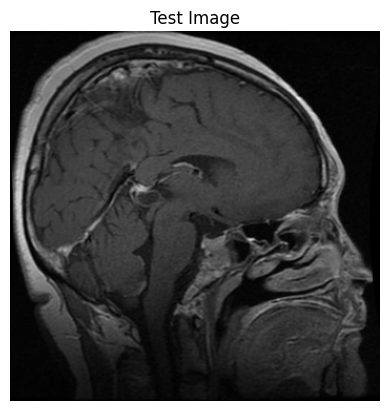

In [21]:
classes_name=['glioma',
'meningioma',
'notumor',
'pituitary']

ix = random.randint(0, len(Y_test) )
classes_names_y=classes_name[np.argmax(y_pred[ix])]

classes_names_y_true=classes_name[Y_test[ix]]



# Display the test image
plt.subplot(1, 1, 1)
plt.imshow(X_test[0])
plt.title('Test Image')
plt.axis('off')

f"Predicted tumor is {classes_names_y} & Truth Tumor is {classes_names_y_true}"

In [53]:
y_pred_classes=[]
for i in range(len(y_pred)):
    y_pred_classes.append(np.argmax(y_pred[i]))
    

In [54]:
y_pred_classes=np.array(y_pred_classes)
y_pred_classes.shape

(1311,)

In [55]:
y_pred_classes[19]

1

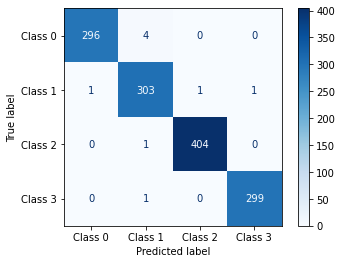

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
# Accuracy


# Precision
precision = precision_score(Y_test, y_pred_classes, average='weighted')  # 'weighted' accounts for imbalanced classes

# Recall
recall = recall_score(Y_test, y_pred_classes, average='weighted')

# F1 Score
f1 = f1_score(Y_test, y_pred_classes, average='weighted')


# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, y_pred_classes)

# Display Confusion Matrix visually
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
conf_matrix_display.plot(cmap='Blues')

In [62]:
accuracy = accuracy_score(Y_test, y_pred_classes)
print(accuracy)

0.9931350114416476


In [60]:
report = classification_report(
    Y_test,
    y_pred_classes,
    target_names=classes_name,
    digits=4,            
    zero_division=0  
)
print(report)

              precision    recall  f1-score   support

      glioma     0.9966    0.9867    0.9916       300
  meningioma     0.9806    0.9902    0.9854       306
     notumor     0.9975    0.9975    0.9975       405
   pituitary     0.9967    0.9967    0.9967       300

    accuracy                         0.9931      1311
   macro avg     0.9929    0.9928    0.9928      1311
weighted avg     0.9932    0.9931    0.9931      1311

